In [1]:
import logging
from gw_scanner import GravWaveScanner

In [2]:
logger = logging.getLogger("quiet_logger")
logger.setLevel(logging.ERROR)

GravWaveScanner can be initialised with optional arguments *gw_name* and *rev*. By default, it loads the most recent LIGO public event, and the most recent revision. Alternatively, a fits file can be saved to the LIGO_skymaps directory, and its name specified with *gw_file*.

In [3]:
gw = GravWaveScanner("S190814bv", prob_threshold=0.90, logger=logger)
# gw = GravWaveScanner(gw_file="GBM-190816-with-LV-v1.fits", prob_threshold=0.9, logger=logger)

Found voevent S190814bv-5-Update.xml
Latest skymap URL: https://gracedb.ligo.org/api/superevents/S190814bv/files/LALInference.v1.fits.gz
Saving to: /Users/robertstein/Code/ZTF_ToO_toolkit/LIGO_skymaps/S190814bv_5_LALInference.v1.fits.gz
Reading file: /Users/robertstein/Code/ZTF_ToO_toolkit/LIGO_skymaps/S190814bv_5_LALInference.v1.fits.gz
MERGER TIME: 2019-08-14T21:10:38.996
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING

Threshold found! 
 To reach 90.00196524902655% of probability, pixels with probability greater than 2.2719458360827667e-05 are included



  2%|▏         | 276683/12582912 [00:00<00:04, 2766799.66it/s]

Threshold found! 
 To reach 90.00196524902655% of probability, pixels with probability greater than 2.2719458360827667e-05 are included
Checking which pixels are within the contour:


100%|██████████| 44/44 [00:00<00:00, 67873.99it/s]

Total pixel area: 23.080575243307088 degrees


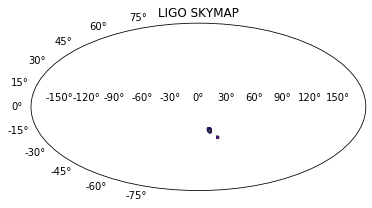

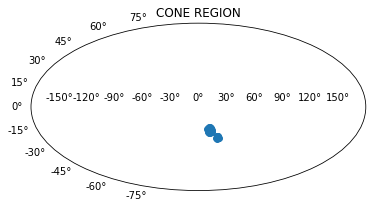

In [4]:
gw.plot_skymap()

In [5]:
gw.scan_cones()

  0%|          | 0/44 [00:00<?, ?it/s]

Commencing Ampel queries!
Scan radius is 0.9541480607387777
So far, 0 pixels out of 44 have already been scanned.


  0%|          | 0/26 [00:00<?, ?it/s]

Scanned 44 pixels
Found 26 candidates
Saving to: /Users/robertstein/Code/ZTF_ToO_toolkit/LIGO_candidates/S190814bv_5_0.9.pdf


//anaconda3/envs/ZTF_ToO/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
100%|██████████| 26/26 [00:07<00:00,  3.87it/s]


In [9]:
# import numpy as np
# mask = gw.data["PROB"] > gw.pixel_threshold
# print("Above", np.sum(gw.data["PROB"][mask][gw.map_coords["dec"] > np.radians(-24.2500 - 3.5)]))

In [10]:
from ztfquery import query
import numpy as np
import datetime
from tqdm import tqdm

class MultiNightSummary(query._ZTFTableHandler_):
    
    def __init__(self, start_date=None, end_date=None):
        self.nights = self.find_nights(start_date, end_date)
        
        print("Using {0} Nightly Sumaries between {1} and {2}".format(
            len(self.nights), self.nights[0], self.nights[-1]))
        
        self.data, self.missing_nights = self.stack_nights()
        
        print("Of these, {0} nights are missing because ZTF did not observe.".format(len(self.missing_nights)))
        
    @staticmethod
    def find_nights(start_date=None, end_date=None):
        date_format = "%Y%m%d"
    
        if start_date is None:
            now = datetime.datetime.now()
            start_time = now - datetime.timedelta(days=30)
        else:
            start_time = datetime.datetime.strptime(start_date, date_format)#.datetime()
            
        
        if end_date is None:
            end_time = datetime.datetime.now()
        else:
            end_time = datetime.datetime.strptime(end_date, date_format).time()
            
        if start_time > end_time:
            raise ValueError("Start time {0} occurs after end time {1}.".format(start_time, end_time))

        delta_t = (end_time - start_time).days
        
        dates = [(start_time + datetime.timedelta(days=x)).strftime(date_format) for x in range(0, delta_t + 1)]
        
        return dates
        
    def stack_nights(self):
        ns = None
        missing_nights = []
    
        for night in tqdm(self.nights[:-1]):
            new_ns = self.get_ztf_data(night)
            
            if ns is None:
                ns = new_ns

            if new_ns is not None:
                ns.data = ns.data.append(new_ns.data)
            else:
                missing_nights.append(night)
                
        return ns.data, missing_nights
    
    @staticmethod
    def get_ztf_data(date=None):
        """Function to grab data for a given date using ztfquery. 
        Date should be given in format YYYYMMDD, with the day being the UT day for the END of the night.
        By default, today is selected. Returns a NightSummary if one is available, or None otherwise 
        (None is returned if there are no ZTF observations).
        """
        if date is None:
            print("No date specified. Assuming today.")
            now = datetime.datetime.now()
            date = now.strftime("%Y%m%d")
        try:
            return query.NightSummary(date)
        # query returns an index error is no ztf data is found
        except IndexError:
            return None
        


  0%|          | 0/7 [00:00<?, ?it/s]

20190814
Using 8 Nightly Sumaries between 20190814 and 20190821


  0%|          | 8/7040 [00:00<01:29, 78.56it/s]

Of these, 0 nights are missing because ZTF did not observe.


100%|██████████| 7040/7040 [01:36<00:00, 73.11it/s]


Observed 0.7274276272629715


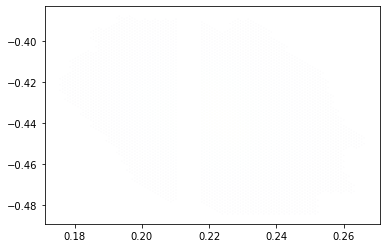

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def check_observations():
    
    time = str(gw.t_min).split("T")[0].replace("-", "")
    print(time)
    
    plt.figure()
    
    mns = MultiNightSummary(start_date=time)
    
    probs = []
    
    decs = list(mns.data["dec"])
    
    plot_ras = []
    plot_decs = []
    
    veto_ras = []
    veto_decs = []
    
    for j, (ra, dec) in enumerate(tqdm(gw.map_coords)):
        ra_deg = np.degrees(ra)
        dec_deg = np.degrees(dec)
        ztf_rad = 3.5
        
        n_obs = 0
        
        for i, x in enumerate(mns.data["ra"]):
            if np.logical_and(ra_deg > float(x) - ztf_rad, ra_deg < float(x) + ztf_rad):
                if np.logical_and(dec_deg > float(decs[i]) - ztf_rad, dec_deg < float(decs[i]) + ztf_rad):
                    n_obs += 1
                    
        if n_obs > 1:
            probs.append(gw.map_probs[j])
            plot_ras.append(ra)
            plot_decs.append(dec)
            
    plt.scatter(gw.wrap_around_180(np.array([plot_ras])), plot_decs,
                 c=probs, vmin=0., vmax=max(gw.data["PROB"]), s=1e-4)
    
    print("Observed", np.sum(probs))
        
        
        
check_observations()